In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
import time
from datetime import datetime

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
# helper to convert a timedelta to a string (dropping milliseconds)
def deltaToString(delta):
    timeObj = time.gmtime(delta.total_seconds())
    return time.strftime('%H:%M:%S', timeObj)

class ProgressBar:
    
    # constructor
    #   maxIterations: maximum number of iterations
    def __init__(self, maxIterations):
        self.maxIterations = maxIterations
        self.granularity = 100 # 1 whole percent
    
    # start the timer
    def start(self):
        self.start = datetime.now()
    
    # check the progress of the current iteration
    #   # currentIteration: the current iteration we are on
    def check(self, currentIteration, chunked=False):
        if currentIteration % round(self.maxIterations / self.granularity) == 0 or chunked:
            
            percentage = round(currentIteration / (self.maxIterations - self.maxIterations / self.granularity) * 100)
            
            current = datetime.now()
            
            # time calculations
            timeElapsed = (current - self.start)
            timePerStep = timeElapsed / (currentIteration + 1)
            totalEstimatedTime = timePerStep * self.maxIterations
            timeRemaining = totalEstimatedTime - timeElapsed
            
            # string formatting
            percentageStr = "{:>3}%  ".format(percentage)
            remainingStr = "Remaining: {}  ".format(deltaToString(timeRemaining))
            elapsedStr = "Elapsed: {}  ".format(deltaToString(timeElapsed))
            totalStr = "Total: {}\r".format(deltaToString(totalEstimatedTime))
            
            print(percentageStr + remainingStr + elapsedStr + totalStr, end="")

In [8]:
def getAgents(dataset, subsetPercent=1):

    datasetLength = round(len(dataset) * subsetPercent)
    pb = ProgressBar(datasetLength)
    pb.start()

    agents = []
    for i in range(0, datasetLength):

        agent = dataset[i]
        track_id = agent[4]
        
        if track_id >= len(agents):
            agents.append([])
        
        centroid = agent[0]
        agents[int(track_id)-1].append(centroid)
        pb.check(i)

    return agents

In [9]:
subsetPercent = 1*10**-1 #1*10**-2
print(subsetPercent)
agents = getAgents(zarr_dataset.agents, subsetPercent)

0.1


In [10]:
def plotAgents(agents):
    r = lambda: random.randint(0,255)
    pb = ProgressBar(len(agents))
    pb.start()
    for i in range(0, len(agents)):
        agent = agents[i]
        centroid_x = []
        centroid_y = []
        for centroid in agent:
            centroid_x.append(centroid[0])
            centroid_y.append(centroid[1])
        plt.plot(centroid_x, centroid_y, 'o', color='#%02X%02X%02X' % (r(),r(),r()))
        pb.check(i)

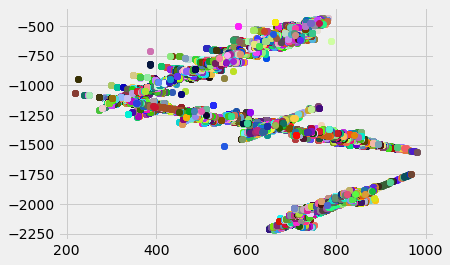

In [11]:
plotAgents(agents)

In [12]:
def printAgentsInfo(agents, limit):
    print("len(agents)", len(agents), "\n")

    agentCentroidLengths = []
    agentsOverLimit = []
    for agent in agents:
        if len(agent) == 0:
            #print(i)
            continue
        agentCentroidLengths.append(len(agent))
        if len(agent) > limit:
            agentsOverLimit.append(agent)

    print("len(agentCentroidLengths)",len(agentCentroidLengths), "\n")

    print("max",np.max(agentCentroidLengths))
    print("min",np.min(agentCentroidLengths))
    print("mean",np.mean(agentCentroidLengths))
    print("std",np.std(agentCentroidLengths), "\n")

    print("agents with {}+ history".format(limit),len(agentsOverLimit))
    return agentsOverLimit

In [13]:
limit = 10
agentsOverLimit = printAgentsInfo(agents, limit)

len(agents) 1999 

len(agentCentroidLengths) 1998 

max 1777
min 1
mean 94.78178178178179
std 124.77865258356093 

agents with 10+ history 1746


In [14]:
def getTrainingSets(agents, limit):
    allTrainingSets = []
    totalNumberOfTrainingSets = 0
    for agent in agentsOverLimit:
        agentTrainingSets = []
        for i in range(limit, len(agent)-1):
            agentTrainingSet = []

            start = i - limit
            end = i
            output = i + 1

            agentTrainingSet.append(agent[start:end])
            agentTrainingSet.append(agent[output])
            agentTrainingSets.append(agentTrainingSet)

            totalNumberOfTrainingSets = totalNumberOfTrainingSets + 1

        allTrainingSets.append(agentTrainingSets)

    print("len(allTrainingSets)", len(allTrainingSets))
    print("len(allTrainingSets[0])",len(allTrainingSets[0]), "\n")

    print("len(agentsOverLimit)",len(agentsOverLimit))
    print("len(agentsOverLimit[0]) - limit - 1",len(agentsOverLimit[0]) - limit - 1, "\n")

    print("totalNumberOfTrainingSets",totalNumberOfTrainingSets)
    return allTrainingSets

In [15]:
allTrainingSets = getTrainingSets(agentsOverLimit, limit)

len(allTrainingSets) 1746
len(allTrainingSets[0]) 1766 

len(agentsOverLimit) 1746
len(agentsOverLimit[0]) - limit - 1 1766 

totalNumberOfTrainingSets 168597


In [16]:
def flattenTrainingSets(allTrainingSets):
    allTrainingSetsFlattened_X = []
    allTrainingSetsFlattened_Y = []
    for allTrainingSet in allTrainingSets:
        for trainingSet in allTrainingSet:
            allTrainingSetsFlattened_X.append(trainingSet[0])
            allTrainingSetsFlattened_Y.append(trainingSet[1])
    print("len(allTrainingSetsFlattened_X)", len(allTrainingSetsFlattened_X))
    return allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y

In [17]:
allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y = flattenTrainingSets(allTrainingSets)

len(allTrainingSetsFlattened_X) 168597


In [18]:
def reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y):
    length = len(allTrainingSetsFlattened_X)
    depth = len(allTrainingSetsFlattened_X[0])
    channels = len(allTrainingSetsFlattened_X[0][0])

    print("length", length)
    print("depth", depth)
    print("channels",channels)
    print("length*depth*channels",length*depth*channels)

    allTrainingSetsFlattened_Input = np.reshape(allTrainingSetsFlattened_X, (length,depth,channels))
    allTrainingSetsFlattened_Output = np.reshape(allTrainingSetsFlattened_Y, (length,1,channels))

    print(allTrainingSetsFlattened_Input.shape[1])
    print(allTrainingSetsFlattened_Input.shape[2])
    
    return allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output

In [19]:
allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y)

length 168597
depth 10
channels 2
length*depth*channels 3371940
10
2


In [20]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(allTrainingSetsFlattened_Input.shape[1],allTrainingSetsFlattened_Input.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=2))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [21]:
# Fitting to the training set
regressor.fit(allTrainingSetsFlattened_Input,allTrainingSetsFlattened_Output,epochs=2,batch_size=32)

Epoch 1/2
5269/5269 [==============================] - 174s 33ms/step - loss: 606748.3750
Epoch 2/2
5269/5269 [==============================] - 175s 33ms/step - loss: 315591.1562


In [22]:
dataset_path_test = dm.require('scenes/test.zarr')
zarr_dataset_test = ChunkedDataset(dataset_path_test)
zarr_dataset_test.open()
print(zarr_dataset_test)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [23]:
print(len(zarr_dataset_test.agents))

88594921


In [24]:
subsetPercent = 1*10**-3
print(subsetPercent)
agentsTest = getAgents(zarr_dataset_test.agents, subsetPercent)

0.001


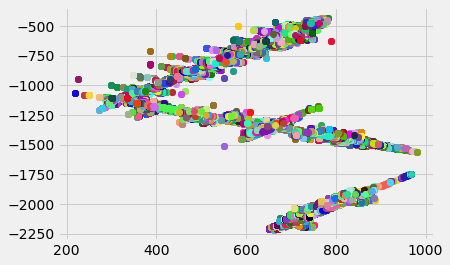

In [25]:
plotAgents(agents)

In [26]:
agentsTestOverLimit = printAgentsInfo(agentsTest, limit)

len(agents) 849 

len(agentCentroidLengths) 848 

max 1071
min 1
mean 104.4752358490566
std 128.82190005548995 

agents with 10+ history 741


In [27]:
allTestingSets = getTrainingSets(agentsTestOverLimit, limit)

len(allTrainingSets) 1746
len(allTrainingSets[0]) 1766 

len(agentsOverLimit) 1746
len(agentsOverLimit[0]) - limit - 1 1766 

totalNumberOfTrainingSets 168597


In [28]:
allTestingSetsFlattened_X, allTestingSetsFlattened_Y = flattenTrainingSets(allTestingSets)

len(allTrainingSetsFlattened_X) 168597


In [29]:
allTestingSetsFlattened_Input, allTestingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTestingSetsFlattened_X, allTestingSetsFlattened_Y)

length 168597
depth 10
channels 2
length*depth*channels 3371940
10
2


In [30]:
max = len(allTestingSetsFlattened_Input)
print(max)
chunkSize = 100
pb = ProgressBar(max)
pb.start()
predictedTestAgentCentroid = [[0,0]]
for i in range(0, max-chunkSize, chunkSize):#len(zarr_dataset.agents)):
    newPredictions = regressor.predict(allTestingSetsFlattened_Input[i:i+chunkSize])
    predictedTestAgentCentroid = np.concatenate((predictedTestAgentCentroid, newPredictions))
    pb.check(i, True)


168597


In [31]:
print(len(predictedTestAgentCentroid))
predictedTestAgentCentroid = predictedTestAgentCentroid[1:len(predictedTestAgentCentroid)]
print(len(predictedTestAgentCentroid))

168501
168500


In [32]:
randomSamples = 10
for i in range(0, len(predictedTestAgentCentroid), round(len(predictedTestAgentCentroid) / randomSamples)):
    testSet = allTestingSetsFlattened_Input[i]
    print(testSet[len(testSet) - 1])
    print(predictedTestAgentCentroid[i])

[  670.90527344 -2198.28198242]
[ 532.49139404 -540.03204346]
[ 560.3762207  -788.05053711]
[ 532.49139404 -540.03204346]
[  678.73986816 -1337.59814453]
[ 532.49139404 -540.03204346]
[  676.85412598 -1329.1730957 ]
[ 532.49139404 -540.03204346]
[ 474.67593384 -902.40826416]
[ 532.49139404 -540.03204346]
[ 585.59216309 -694.45526123]
[ 532.49139404 -540.03204346]
[  357.41549683 -1079.41845703]
[ 532.49139404 -540.03204346]
[ 736.81530762 -542.50097656]
[ 532.49139404 -540.03204346]
[ 736.32263184 -571.19403076]
[ 532.49139404 -540.03204346]
[  763.92279053 -1987.4407959 ]
[ 532.49139404 -540.03204346]
